In [1]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
#sc.stop()
spark.stop()

In [3]:
spark = SparkSession.builder.appName('MNIST digit classified')\
    .config('spark.executor.instances', 10)\
    .getOrCreate()

In [4]:
spark

In [5]:
mnist_train = spark.read.csv("file:///home/hadoop/data/train (1).csv", header=True, inferSchema='true', )
mnist_test = spark.read.csv("file:///home/hadoop/data/test (1).csv",header=True, inferSchema= 'true', )

In [6]:
assert {r[1] for r in mnist_train.dtypes+mnist_test.dtypes} == {'int'}

In [7]:
mnist_test.dtypes
# for df in [mnist_train, mnist_test]:
#     for col_ in df.columns:
#         df = df.withColumn(col_, df[col_].cast('int'))
#     df.cache()

       
# mnist_train.printSchema()
# Maybe there is some hidden commonality in my and Sly's setup? Like 64bit windows running 32bit Ubuntu or something?

[('pixel0', 'int'),
 ('pixel1', 'int'),
 ('pixel2', 'int'),
 ('pixel3', 'int'),
 ('pixel4', 'int'),
 ('pixel5', 'int'),
 ('pixel6', 'int'),
 ('pixel7', 'int'),
 ('pixel8', 'int'),
 ('pixel9', 'int'),
 ('pixel10', 'int'),
 ('pixel11', 'int'),
 ('pixel12', 'int'),
 ('pixel13', 'int'),
 ('pixel14', 'int'),
 ('pixel15', 'int'),
 ('pixel16', 'int'),
 ('pixel17', 'int'),
 ('pixel18', 'int'),
 ('pixel19', 'int'),
 ('pixel20', 'int'),
 ('pixel21', 'int'),
 ('pixel22', 'int'),
 ('pixel23', 'int'),
 ('pixel24', 'int'),
 ('pixel25', 'int'),
 ('pixel26', 'int'),
 ('pixel27', 'int'),
 ('pixel28', 'int'),
 ('pixel29', 'int'),
 ('pixel30', 'int'),
 ('pixel31', 'int'),
 ('pixel32', 'int'),
 ('pixel33', 'int'),
 ('pixel34', 'int'),
 ('pixel35', 'int'),
 ('pixel36', 'int'),
 ('pixel37', 'int'),
 ('pixel38', 'int'),
 ('pixel39', 'int'),
 ('pixel40', 'int'),
 ('pixel41', 'int'),
 ('pixel42', 'int'),
 ('pixel43', 'int'),
 ('pixel44', 'int'),
 ('pixel45', 'int'),
 ('pixel46', 'int'),
 ('pixel47', 'int'),
 (

In [8]:
mnist_train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- pixel0: integer (nullable = true)
 |-- pixel1: integer (nullable = true)
 |-- pixel2: integer (nullable = true)
 |-- pixel3: integer (nullable = true)
 |-- pixel4: integer (nullable = true)
 |-- pixel5: integer (nullable = true)
 |-- pixel6: integer (nullable = true)
 |-- pixel7: integer (nullable = true)
 |-- pixel8: integer (nullable = true)
 |-- pixel9: integer (nullable = true)
 |-- pixel10: integer (nullable = true)
 |-- pixel11: integer (nullable = true)
 |-- pixel12: integer (nullable = true)
 |-- pixel13: integer (nullable = true)
 |-- pixel14: integer (nullable = true)
 |-- pixel15: integer (nullable = true)
 |-- pixel16: integer (nullable = true)
 |-- pixel17: integer (nullable = true)
 |-- pixel18: integer (nullable = true)
 |-- pixel19: integer (nullable = true)
 |-- pixel20: integer (nullable = true)
 |-- pixel21: integer (nullable = true)
 |-- pixel22: integer (nullable = true)
 |-- pixel23: integer (nullable = true)
 |-- pi

In [9]:
mnist_train.count(),mnist_test.count()

(42000, 28000)

In [10]:
mnist_train.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 4684|
|    6| 4137|
|    3| 4351|
|    5| 3795|
|    9| 4188|
|    4| 4072|
|    8| 4063|
|    7| 4401|
|    2| 4177|
|    0| 4132|
+-----+-----+



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
npa_0 = np.asarray(mnist_train.head())#, dtype=float)

# help(np.asarray)
# Str??

In [13]:
28*28

784

In [14]:
npa_0 # changed dtype

array([  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 188, 255,  94,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 191, 250, 253,  93,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [15]:

# ok!

In [16]:
if 0:
    plt.imshow(np.reshape(np.asarray(mnist_train.head()[1:], dtype=int), (28,28),), cmap='gray')
    plt.title("Label %i" %np.asarray(mnist_train.head()[0]))
    plt.show()


In [17]:
if 0:
    for _r_ in mnist_train.head(10):
        plt.imshow(np.reshape(np.asarray(_r_ [1:], dtype=int), (28,28),), cmap='gray')
        plt.title("Label %i" %np.asarray(_r_[0]))
        plt.show()


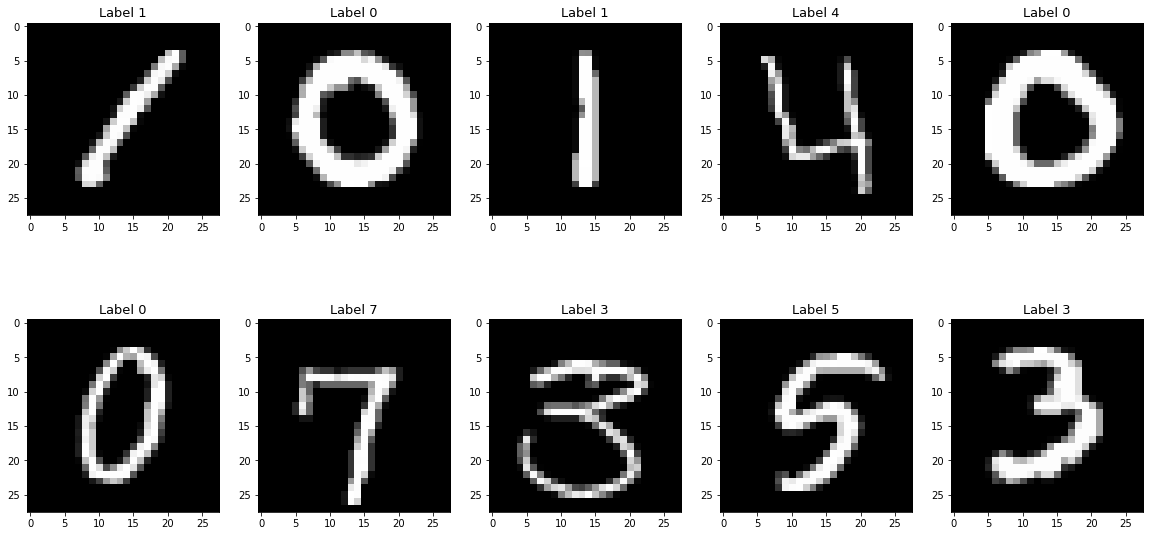

In [18]:
# Subplotting 
plt.figure(figsize=(20,10))

for index, (image, label) in enumerate(zip(np.asarray(mnist_train.head(10), dtype=int)[:, 1:], 
                                           np.asarray(mnist_train.head(10), dtype=int)[:, 0])):
    plt.subplot(2, 5, index +1)
    plt.imshow(np.reshape(image, (28,28)), cmap = 'gray')
    plt.title("Label %i"%label ,fontsize = 13)
plt.show()


In [19]:
# total 784 features
FEATURE_NUM = 784
# assemble features to a vector to consume in spark ml
assembler = VectorAssembler(
                    inputCols=["pixel{0}".format(i) for i in range(0,FEATURE_NUM)], 
                    outputCol="features")


In [20]:
labeledPoints = assembler.transform(mnist_train).select("label", "features")

labeledPoints.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(784,[132,133,134...|
|    0|(784,[122,123,124...|
|    1|(784,[124,125,126...|
|    4|(784,[146,147,148...|
|    0|(784,[121,122,123...|
|    0|(784,[124,125,126...|
|    7|(784,[202,203,204...|
|    3|(784,[177,178,179...|
|    5|(784,[153,154,155...|
|    3|(784,[119,120,121...|
|    8|(784,[180,181,182...|
|    9|(784,[182,183,184...|
|    1|(784,[154,155,156...|
|    3|(784,[144,145,146...|
|    3|(784,[122,123,124...|
|    1|(784,[156,157,158...|
|    2|(784,[148,149,150...|
|    0|(784,[129,130,131...|
|    7|(784,[206,207,208...|
|    5|(784,[121,122,123...|
+-----+--------------------+
only showing top 20 rows



In [21]:
indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
labeledPoints = indexer.fit(labeledPoints).transform(labeledPoints)

In [22]:
labeledPoints.show()


+-----+--------------------+----------+
|label|            features|labelIndex|
+-----+--------------------+----------+
|    1|(784,[132,133,134...|       0.0|
|    0|(784,[122,123,124...|       6.0|
|    1|(784,[124,125,126...|       0.0|
|    4|(784,[146,147,148...|       7.0|
|    0|(784,[121,122,123...|       6.0|
|    0|(784,[124,125,126...|       6.0|
|    7|(784,[202,203,204...|       1.0|
|    3|(784,[177,178,179...|       2.0|
|    5|(784,[153,154,155...|       9.0|
|    3|(784,[119,120,121...|       2.0|
|    8|(784,[180,181,182...|       8.0|
|    9|(784,[182,183,184...|       3.0|
|    1|(784,[154,155,156...|       0.0|
|    3|(784,[144,145,146...|       2.0|
|    3|(784,[122,123,124...|       2.0|
|    1|(784,[156,157,158...|       0.0|
|    2|(784,[148,149,150...|       4.0|
|    0|(784,[129,130,131...|       6.0|
|    7|(784,[206,207,208...|       1.0|
|    5|(784,[121,122,123...|       9.0|
+-----+--------------------+----------+
only showing top 20 rows



In [23]:
# Random Forest

In [24]:
#impurity = 'gini' # alternative option to "entropy"

rf_classifier = RandomForestClassifier(labelCol='labelIndex', featuresCol='features',impurity="entropy", maxBins=32)

pipeline = Pipeline(stages=[rf_classifier])

In [25]:
# Define the param grids to serach for best hyper parameters 
# values of alpha in regression , depth of tree - in DT , depth + num of trees are hyper-parameters 
paramGrid = ParamGridBuilder()\
            .addGrid(rf_classifier.numTrees , range(3, 11))\
            .addGrid(rf_classifier.maxDepth, range(4, 12)).build()
            

In [26]:
# Cross validation


In [27]:
crossval = CrossValidator(estimator= pipeline, 
                         estimatorParamMaps=paramGrid, 
                         evaluator=MulticlassClassificationEvaluator(), 
                         numFolds=3)

In [28]:
#%%time
cvmodel=crossval.fit(labeledPoints)

Py4JJavaError: An error occurred while calling o6323.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 537.0 failed 1 times, most recent failure: Lost task 3.0 in stage 537.0 (TID 2141, localhost, executor driver): java.lang.IllegalArgumentException: EntropyAggregator given label 0.0but requires label is non-negative.
	at org.apache.spark.mllib.tree.impurity.EntropyAggregator.update(Entropy.scala:99)
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.updateParent(DTStatsAggregator.scala:116)
	at org.apache.spark.ml.tree.impl.RandomForest$.org$apache$spark$ml$tree$impl$RandomForest$$nodeBinSeqOp$1(RandomForest.scala:437)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:458)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:455)
	at scala.collection.immutable.Map$Map3.foreach(Map.scala:161)
	at org.apache.spark.ml.tree.impl.RandomForest$.org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1(RandomForest.scala:455)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$apply$8.apply(RandomForest.scala:549)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$apply$8.apply(RandomForest.scala:549)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:549)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:538)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1925)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1913)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1912)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1912)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:948)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:948)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:948)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2146)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2095)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2084)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:759)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:567)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:201)
	at org.apache.spark.ml.classification.RandomForestClassifier$$anonfun$train$1.apply(RandomForestClassifier.scala:142)
	at org.apache.spark.ml.classification.RandomForestClassifier$$anonfun$train$1.apply(RandomForestClassifier.scala:120)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:120)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.GeneratedMethodAccessor130.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.IllegalArgumentException: EntropyAggregator given label 0.0but requires label is non-negative.
	at org.apache.spark.mllib.tree.impurity.EntropyAggregator.update(Entropy.scala:99)
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.updateParent(DTStatsAggregator.scala:116)
	at org.apache.spark.ml.tree.impl.RandomForest$.org$apache$spark$ml$tree$impl$RandomForest$$nodeBinSeqOp$1(RandomForest.scala:437)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:458)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:455)
	at scala.collection.immutable.Map$Map3.foreach(Map.scala:161)
	at org.apache.spark.ml.tree.impl.RandomForest$.org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1(RandomForest.scala:455)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$apply$8.apply(RandomForest.scala:549)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$apply$8.apply(RandomForest.scala:549)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:549)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:538)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
cvmodel

In [ ]:
bestModel = cvmodel.bestModel

In [ ]:
testlabels = assembler.transform(mnist_train).select("label", "features")
testlabels.show()

testlabels = indexer.fit(testlabels).transform(testlabels)

testPrediction = bestModel.transform(testlabels)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction', labelCol = 'labelIndex', metricName = 'accuracy')

In [ ]:
print("Accuracy : ", str(evaluator.evaluate(testPrediction)))

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answ

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40983)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40983)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40983)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40983)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception